In [1]:
import sys
import os
# sys.path.append(os.path.abspath('/home/kinga/mnt2'))
# sys.path.append(os.path.abspath('/home/kinga/mnt3'))
# sys.path.append(os.path.abspath('/home/kinga/mnt4'))
# sys.path.append(os.path.abspath('/home/kinga/mnt5'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../util'))
sys.path.append(os.path.abspath('../analysis'))
from collections import namedtuple
import pathlib
import mplhep as hep
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jli
import numpy as np
import pandas as pd

import laspaclu.util.logging as log
import laspaclu.util.string_constants as stco
import laspaclu.util.persistence as pers
import laspaclu.analysis.plotting as plott
import pofah.jet_sample as jesa


In [23]:
#****************************************#
#           Runtime Params
#****************************************#


Parameters = namedtuple('Parameters', 'run_n latent_dim ae_run_n read_n sample_id_qcd sample_id_sigs raw_format')
params = Parameters(run_n=48, 
                    latent_dim=4,
                    ae_run_n=50, 
                    read_n=int(2e2), # test on 20K events in 10 fold (10x2000)
                    sample_id_qcd='qcdSigExt',
                    sample_id_sigs=['GtoWW35na', 'GtoWW15br', 'AtoHZ35'], 
                    raw_format=True)

# logging
logger = log.get_logger(__name__)
logger.info('\n'+'*'*70+'\n'+'\t\t\t PLOTING RUN \n'+str(params)+'\n'+'*'*70)

2022-11-28 14:58:23 [<ipython-input-23-7f92bb132c14>:<module>] 
**********************************************************************
			 PLOTING RUN 
Parameters(run_n=48, latent_dim=4, ae_run_n=50, read_n=200, sample_id_qcd='qcdSigExt', sample_id_sigs=['GtoWW35na', 'GtoWW15br', 'AtoHZ35'], raw_format=True)
**********************************************************************
2022-11-28 14:58:23 [<ipython-input-23-7f92bb132c14>:<module>] 
**********************************************************************
			 PLOTING RUN 
Parameters(run_n=48, latent_dim=4, ae_run_n=50, read_n=200, sample_id_qcd='qcdSigExt', sample_id_sigs=['GtoWW35na', 'GtoWW15br', 'AtoHZ35'], raw_format=True)
**********************************************************************
2022-11-28 14:58:23 [<ipython-input-23-7f92bb132c14>:<module>] 
**********************************************************************
			 PLOTING RUN 
Parameters(run_n=48, latent_dim=4, ae_run_n=50, read_n=200, sample_id_qcd='qcdSigExt',

In [24]:
#****************************************#
#               READ DATA
#****************************************#
input_data_dir = stco.cluster_out_data_dir+'/run_'+str(params.run_n)
# import ipdb; ipdb.set_trace()
sample_qcd = jesa.JetSampleLatent.from_input_file(name=params.sample_id_qcd, path=input_data_dir+'/'+params.sample_id_qcd+'.h5').filter(slice(params.read_n))
sample_sigs = {}
for sample_id_sig in params.sample_id_sigs:
    sample_sigs[sample_id_sig] = jesa.JetSampleLatent.from_input_file(name=sample_id_sig, path=input_data_dir+'/'+sample_id_sig+'.h5').filter(slice(params.read_n))

dist_qcd = sample_qcd['classic_loss']
dist_q_qcd = sample_qcd['quantum_loss']

dist_sigs = {}
dist_q_sigs = {}
for sample_id_sig in params.sample_id_sigs:
    dist_sigs[sample_id_sig] = sample_sigs[sample_id_sig]['classic_loss']
    dist_q_sigs[sample_id_sig] = sample_sigs[sample_id_sig]['quantum_loss']

In [25]:
print('read ' + str(len(sample_qcd)) + ' qcd samples')

read 100 qcd samples


In [26]:
#****************************************#
#           Read in Models
#****************************************#

model_path_km = pers.make_model_path(prefix='KM', run_n=params.run_n)
logger.info('loading clustering model ' + model_path_km)

cluster_model = jli.load('../'+model_path_km+'.joblib')    
centers_c = cluster_model.cluster_centers_
logger.info('classic cluster centers: ')
logger.info(centers_c)


## quantum model (distance calc and minimization = quantum)

logger.info('loading qmeans')
model_path_qm = pers.make_model_path(prefix='QM', run_n=params.run_n) + '.npy'
with open('../'+model_path_qm, 'rb') as f:
    centers_q = np.load(f)
logger.info('quantum cluster centers: ')
logger.info(centers_q)


2022-11-28 14:58:56 [<ipython-input-26-634c69639dc3>:<module>] loading clustering model models/saved/KMmodel_run48
2022-11-28 14:58:56 [<ipython-input-26-634c69639dc3>:<module>] loading clustering model models/saved/KMmodel_run48
2022-11-28 14:58:56 [<ipython-input-26-634c69639dc3>:<module>] loading clustering model models/saved/KMmodel_run48
2022-11-28 14:58:56 [<ipython-input-26-634c69639dc3>:<module>] classic cluster centers: 
2022-11-28 14:58:56 [<ipython-input-26-634c69639dc3>:<module>] classic cluster centers: 
2022-11-28 14:58:56 [<ipython-input-26-634c69639dc3>:<module>] classic cluster centers: 
2022-11-28 14:58:56 [<ipython-input-26-634c69639dc3>:<module>] [[-0.44364434 -0.11226088 -0.23964873 -0.24257118]
 [-0.12761594 -0.5435193  -0.4144419  -0.6051253 ]]
2022-11-28 14:58:56 [<ipython-input-26-634c69639dc3>:<module>] [[-0.44364434 -0.11226088 -0.23964873 -0.24257118]
 [-0.12761594 -0.5435193  -0.4144419  -0.6051253 ]]
2022-11-28 14:58:56 [<ipython-input-26-634c69639dc3>:<mo

In [28]:
### assemble to dataframe (8 latent dimensions)
columns = ["d"+str(i) for i in range(0,params.latent_dim)]
centroids_classic = pd.DataFrame(centers_c, columns=columns)
centroids_quantum = pd.DataFrame(centers_q, columns=columns)
centroids = centroids_classic.append(centroids_quantum, ignore_index=True)
centroids['algorithm'] = ['classic']*2 + ['quantum']*2

In [29]:
centroids

,d0,d1,d2,d3,algorithm
0,-0.443644,-0.112261,-0.239649,-0.242571,classic
1,-0.127616,-0.543519,-0.414442,-0.605125,classic
2,-0.434606,-0.124136,-0.243789,-0.256402,quantum
3,-0.125406,-0.546880,-0.416307,-0.605067,quantum


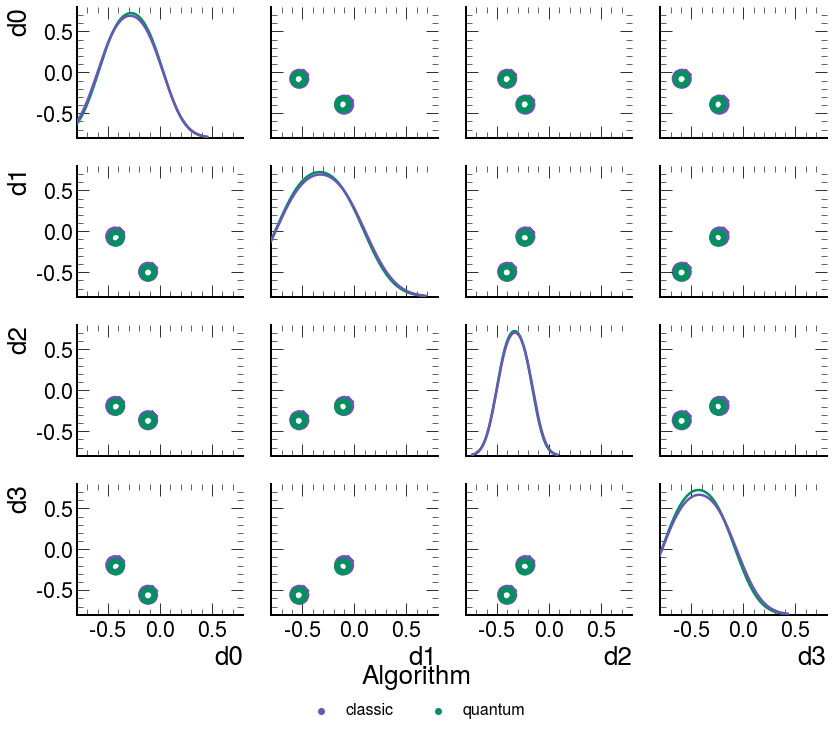

In [138]:
#****************************************#
#           Plot Scatter
#****************************************#
sns.set_style(hep.style.CMS)

#gg = sns.pairplot(centroids, hue='algorithm', markers='o', plot_kws={'s': 10}, palette = ['#D62828', '#74A57F'])
val = 0.8
palette = ['#6C56B3', '#008F5F']

gg = sns.pairplot(centroids, hue='algorithm', markers="$\circ$", plot_kws=dict(s=[700,700,500,500], c=['#6C56B3', '#6C56B3', '#008F5F', '#008F5F'], edgecolor=['#6C56B3', '#6C56B3', '#008F5F', '#008F5F']), diag_kws=dict(alpha=1., fill=False, lw=2.5), palette=palette)
gg.set(xlim=(-val,val))
gg.set(ylim=(-val,val))
#for ax in gg.axes.flat:
#    ax.set_xlim((-val,val))
#    ax.set_ylim((-val,val))
#for ax in gg.diag_axes:
#    ax.set_xlim((-1,1))   
sns.move_legend(gg, bbox_to_anchor=(0.5, -0.05), loc="lower center", ncol=2, labelspacing=0.8, fontsize=16, title='Algorithm')
plt.tight_layout()
plt.draw()
#plt.savefig(fig_dir+'/center_pair_scatter_classic_vs_quantum.png')

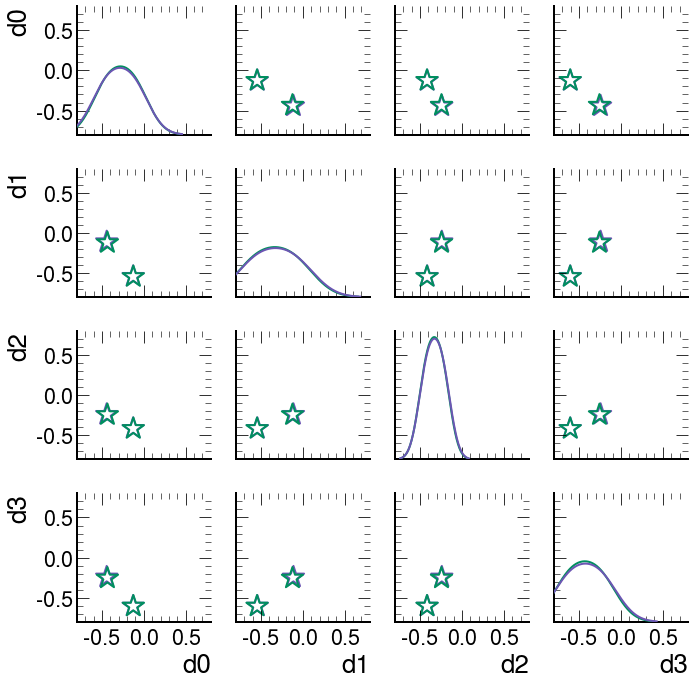

In [129]:
gg = sns.PairGrid(centroids,hue='algorithm',hue_kws={"edgecolor": palette})
#gg.map_offdiag(sns.scatterplot, palette=palette, alpha=0.7, size=[0.1,0.11,2,2], markers='o', markerfacecolor=None)
gg.map_offdiag(plt.scatter, marker='*', facecolor="none", s=500, lw=2)
gg.map_diag(sns.kdeplot, palette=palette, warn_singular=False, lw=2)
gg.set(xlim=(-val,val))
gg.set(ylim=(-val,val))

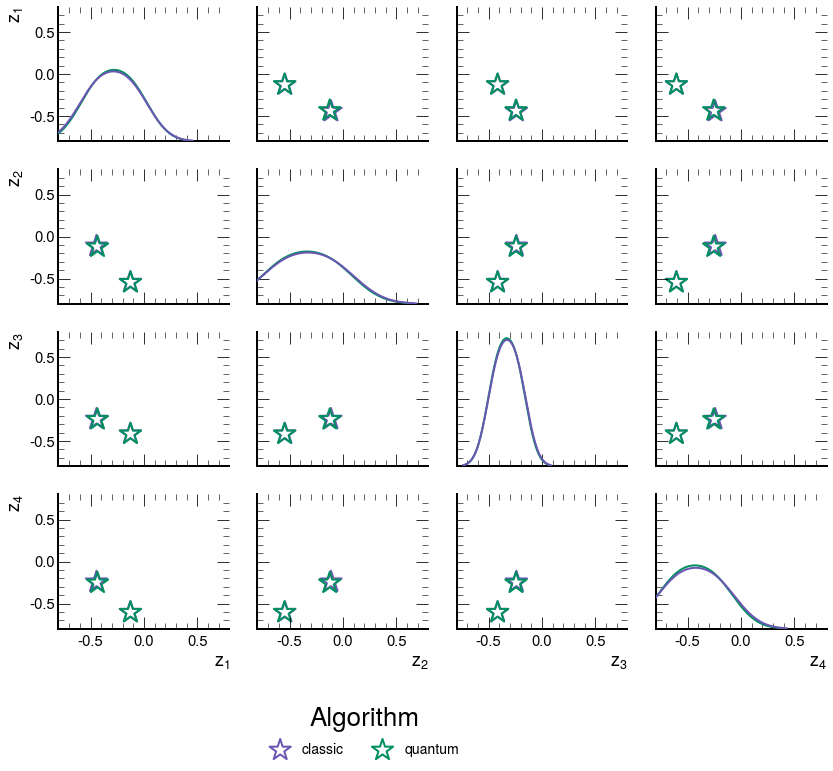

In [142]:
Z = centers_c.shape[1]
columns = [r'$z_{}$'.format(i) for i in range(1,Z+1)]
centroids = pd.DataFrame(centers_c, columns=columns)
centroids_quantum = pd.DataFrame(centers_q, columns=columns)
centroids = centroids.append(centroids_quantum, ignore_index=True)
centroids['algorithm'] = ['classic']*2 +['quantum']*2

palette = ['#6C56B3', '#008F5F']
val = 0.8

#gg = sns.pairplot(centroids, hue='algorithm', markers='X', plot_kws=dict(alpha=0.9, s=500), diag_kind="hist", diag_kws=dict(alpha=0.7, shrink=0.6, edgecolor=None), palette=palette)

gg = sns.PairGrid(centroids,hue='algorithm',hue_kws={"edgecolor": palette})
gg.map_offdiag(plt.scatter, marker='*', facecolor="none", s=500, lw=2)
gg.map_diag(sns.kdeplot, palette=palette, warn_singular=False, lw=2)
gg.add_legend()
gg.set(xlim=(-val,val))
gg.set(ylim=(-val,val))

for ax in gg.figure.axes:
    ax.tick_params(labelsize=15)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
for ax in gg.diag_axes:
    ax.tick_params(labelsize=15)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

sns.move_legend(gg, bbox_to_anchor=(0.44, -0.1), loc="lower center", ncol=2, labelspacing=0.8, fontsize=14, markerscale=1, title='Algorithm')
plt.tight_layout()